## Import libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict, Optional
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import *

from darts.datasets import TrafficDataset, AirPassengersDataset, AustralianTourismDataset
from ucimlrepo import fetch_ucirepo 

## Import Data
- We try multiple datasets to see which provides us with the best outcome

In [2]:
room_occupancy_estimation = fetch_ucirepo(id=864) 
room_df = room_occupancy_estimation['data']['features']
room_df = pd.concat([room_df, room_occupancy_estimation['data']['targets']], axis = 1)
room_df['Capacity %'] = room_df['Room_Occupancy_Count']/max(room_df['Room_Occupancy_Count'])

airpass_raw = AirPassengersDataset().load().pd_dataframe().reset_index()
airpass_raw.columns.name = None

airpass_raw

,Month,#Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


## Airpassenger Model

### Data preprocessing
- Scale the data
    - Make sure each data entry is $0\leq x\leq 1$

In [3]:
## Find local minimums and plot the month
airpass_data = airpass_raw.copy()
airpass_data['LMin'] = 0
airpass_data['LMax'] = 0
passengers = []

for row, index in airpass_data.iterrows():
    passengers.append(index['#Passengers'])
    
for i in range(len(passengers)):
    if i > 0 and i < len(passengers)-1:
        if passengers[i] < passengers[i-1] and passengers[i] < passengers[i+1]:
            airpass_data.loc[i, "LMin"] = 1
        if passengers[i] > passengers[i-1] and passengers[i] > passengers[i+1]:
            airpass_data.loc[i, "LMax"] = 1

## Keep out these values to prevent any errors
to_conc = airpass_data[['Month', "LMin", "LMax"]]

## Scale train and test
scaler = MaxAbsScaler()
airpass_scaled_data = pd.DataFrame(scaler.fit_transform(np.array(airpass_data.drop(columns = ['Month', "LMin", "LMax"])))).rename(columns = {0:"# Passengers"})

## Add month to both
airpass_scaled_data = pd.concat([to_conc, airpass_scaled_data], axis = 1)
airpass_scaled_data

,Month,LMin,LMax,# Passengers
0,1949-01-01,0,0,0.180064
1,1949-02-01,0,0,0.189711
2,1949-03-01,0,1,0.212219
3,1949-04-01,0,0,0.207395
4,1949-05-01,1,0,0.194534
...,...,...,...,...
139,1960-08-01,0,0,0.974277
140,1960-09-01,0,0,0.816720
141,1960-10-01,0,0,0.741158
142,1960-11-01,1,0,0.627010


### Plot scaled data
- Looking at the data we see some trends
    - Cyclical in nature
    - Upward trend from 1950 onwards

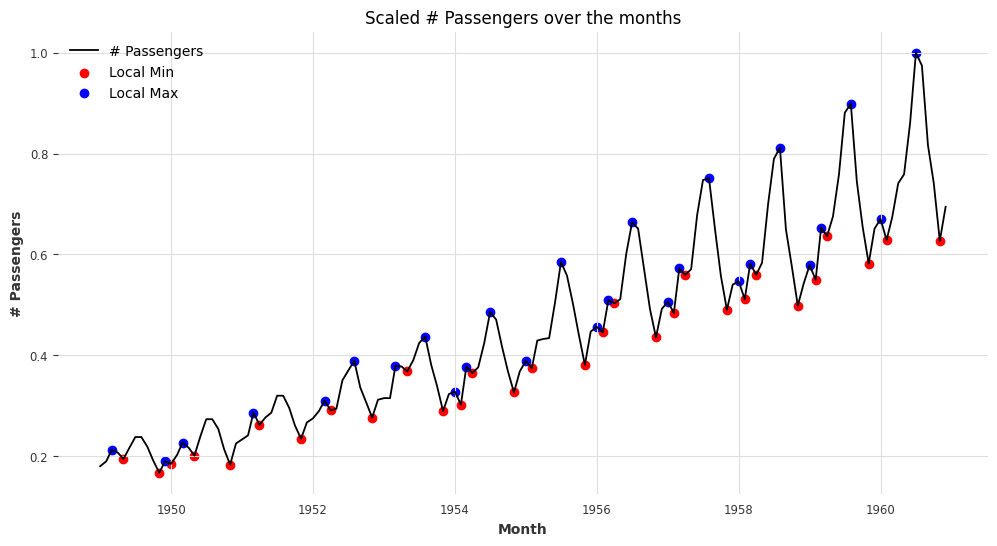

In [4]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))
lmins = airpass_scaled_data[airpass_scaled_data['LMin'] == 1]
lmaxs = airpass_scaled_data[airpass_scaled_data['LMax'] == 1]

axes.plot(airpass_scaled_data['Month'], airpass_scaled_data['# Passengers'], label = '# Passengers')
axes.set_xlabel("Month")
axes.set_ylabel("# Passengers")
axes.set_title("Scaled # Passengers over the months")
axes.scatter(lmins['Month'], lmins['# Passengers'], color='red', label = 'Local Min')
axes.scatter(lmaxs['Month'], lmaxs['# Passengers'], color='blue', label = 'Local Max')
axes.legend()

plt.show()

### Fit a model on the data
- Invert the data

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


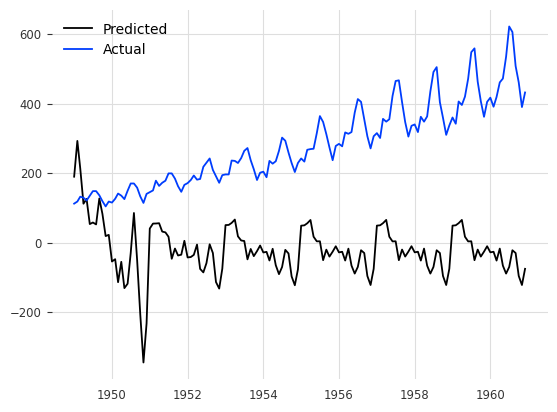

MSE = 112850.223 
MAPE = 305.21


In [5]:
## Format to TimeSeries
past = 24
future = 24
airpass_ts = TimeSeries.from_dataframe(airpass_scaled_data, "Month", "# Passengers")
airpass_ts = airpass_ts.astype('float32')

model = NHiTSModel(input_chunk_length = past, output_chunk_length = future)
model.fit(airpass_ts, verbose = 0)

## Predict on self
pred = model.predict(n = len(airpass_scaled_data['Month']), verbose = 0)

## Plot predict v train
results_df = pd.DataFrame(scaler.inverse_transform(pred.values())).rename(columns = {0:"Predicted"})
results_df = pd.concat([airpass_scaled_data['Month'], results_df, \
                        pd.DataFrame(scaler.inverse_transform(airpass_ts.values()))], axis = 1)\
                        .rename(columns = {0:"Actual"})

plt.plot(results_df['Month'], results_df['Predicted'], label = 'Predicted')
plt.plot(results_df['Month'], results_df['Actual'], label = 'Actual')
plt.legend()
plt.show()

mse = round(sum((results_df['Predicted'] - results_df['Actual'])**2)/len(results_df['Predicted']), 3)
mape = round(sum(abs((results_df['Predicted'] - results_df['Actual'])))/len(results_df['Predicted']), 3)

print("MSE =", mse, "\nMAPE =", mape)

## Air dataset
- https://www.opendatanetwork.com/dataset/datahub.transportation.gov/xgub-n9bw

In [ ]:
carrier_raw = pd.read_csv("carrier_passengers.csv")
carrier_df = carrier_raw[carrier_raw['Year'] == 2023].sort_values(by = 'data_dte').reset_index(drop = True)
carrier_df = carrier_df.drop(columns=["data_dte", "usg_apt_id", "usg_wac", "fg_apt_id", "fg_wac", "airlineid", "type", "Scheduled", "Charter"])

carrier_df

,Year,Month,usg_apt,fg_apt,carrier,carriergroup,Total
0,2023,1,MIA,CLO,AA,1,18315
1,2023,1,IAD,DND,AOQ,0,3
2,2023,1,IAD,DEL,AI,0,5385
3,2023,1,IAD,CPT,UA,1,5662
4,2023,1,IAD,CPH,SK,0,5190
...,...,...,...,...,...,...,...
32448,2023,12,TEB,LBG,VJT,0,7
32449,2023,12,TEB,LBG,1HQ,0,7
32450,2023,12,TEB,KEF,AOQ,0,7
32451,2023,12,TEB,LTN,HUQ,0,2


### Numeric encoding
- Tried one-hot and PCA, didn't work well
    - Create the encoding for the flight and carrier, and use pca to determine which columns are most useful in determining the total

In [ ]:
carrier_df

,Year,Month,usg_apt,fg_apt,carrier,carriergroup,Total
0,2023,1,MIA,CLO,AA,1,18315
1,2023,1,IAD,DND,AOQ,0,3
2,2023,1,IAD,DEL,AI,0,5385
3,2023,1,IAD,CPT,UA,1,5662
4,2023,1,IAD,CPH,SK,0,5190
...,...,...,...,...,...,...,...
32448,2023,12,TEB,LBG,VJT,0,7
32449,2023,12,TEB,LBG,1HQ,0,7
32450,2023,12,TEB,KEF,AOQ,0,7
32451,2023,12,TEB,LTN,HUQ,0,2


In [ ]:
columns_to_encode = ['usg_apt', 'fg_apt', 'carrier']
temp_df = carrier_df.copy()
temp_df = temp_df[columns_to_encode]

## Scale variables
standard_scaler = StandardScaler()
model_df = pd.DataFrame(standard_scaler.fit_transform(carrier_df.drop(columns = columns_to_encode)))
model_df = pd.concat([model_df, temp_df], axis=1)

## Construct encoders
le_usg_apt = LabelEncoder()
le_fg_apt = LabelEncoder()
le_carrier = LabelEncoder()

## Encode the data
model_df['usg_apt_encoded'] = le_usg_apt.fit_transform(model_df['usg_apt'])
model_df['fg_apt_encoded'] = le_fg_apt.fit_transform(model_df['fg_apt'])
model_df['carrier_encoded'] = le_carrier.fit_transform(model_df['carrier'])
model_df = model_df.drop(columns=['usg_apt', 'fg_apt', 'carrier']).rename(columns = {0: "Year", 1:"Month", 2:"carriergroup", 3:"Total"})

# ## Conduct PCA
# pca = PCA()
# pca.fit(one_hot_scaled)
# one_hot_pca = pca.transform(one_hot_scaled)
# explained_var = pca.explained_variance_ratio_

# # ## Remove low variability
# # one_hot.loc[-1] = list(explained_var)
# # columns_to_drop = one_hot.columns[one_hot.iloc[-1] < (max(list(explained_var)) + min(list(explained_var)))/2]
# # one_hot = one_hot.drop(columns=columns_to_drop)
# # one_hot = one_hot.drop(-1)
# # one_hot.head()

model_df.head()

,Year,Month,carriergroup,Total,usg_apt_encoded,fg_apt_encoded,carrier_encoded
0,0.0,-1.597038,0.975555,1.154881,214,127,48
1,0.0,-1.597038,-1.025057,-0.767303,157,164,56
2,0.0,-1.597038,-1.025057,-0.202362,157,160,52
3,0.0,-1.597038,0.975555,-0.173286,157,140,184
4,0.0,-1.597038,-1.025057,-0.222831,157,139,170


### Fit the model

In [ ]:
air_model_df = model_df.copy()

target = air_model_df['Total']
predictors = air_model_df.drop(columns=['Total', "Year"])

## Format to TimeSeries
past = 24
future = 24
predictors_ts = TimeSeries.from_dataframe(predictors)
predictors_ts = predictors_ts.astype('float32')

model = NHiTSModel(input_chunk_length = past, output_chunk_length = 5)
model.fit(predictors_ts, epochs=100)

## Predict on self
pred = model.predict(n = len(air_model_df['Month']))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.0 M     Trainable params
61.6 K    Non-trainable params
1.1 M     Total params
4.249     Total estimated model params size (MB)


Epoch 23:  90%|█████████ | 913/1014 [00:15<00:01, 58.47it/s, train_loss=5.1e+3]  

In [ ]:
## Plot predict v train
# results_df = pd.DataFrame(standard_scaler.inverse_transform(pred.values()))
# results_df = pd.concat([carrier_df['Month'], results_df, \
#                         target], axis = 1)
# results_df = results_df[['Month', 'Predicted', 'Total']]
# results_df = results_df.groupby(by = 'Month').sum().reset_index()

# plt.plot(results_df['Month'], results_df['Predicted'], label = 'Predicted')
# plt.plot(results_df['Month'], results_df['Actual'], label = 'Actual')
# plt.legend()
# plt.show()

# mse = round(sum((results_df['Predicted'] - results_df['Actual'])**2)/len(results_df['Predicted']), 3)
# mape = round(sum(abs((results_df['Predicted'] - results_df['Actual'])))/len(results_df['Predicted']), 3)

# print("MSE =", mse, "\nMAPE =", mape)
pred.values()